# <b style='color:orange'> Landmark Registration — using the built in MMoCHi function

**Author:** Daniel Caron

#### In this notebook, we walk through how to fine-tune the landmark registration performed in the MMoCHi package. 
    
#### Landmark registration can also be achieved using [ADTnorm in R](https://github.com/yezhengSTAT/ADTnorm) or the [Python wrapper for it](https://github.com/donnafarberlab/ADTnormPy)
   This fine-tuning is useful for correcting the peak identification made by landmark registration, such that landmark-registered ADT expression distributions aren't incorrectly shifted.

## <b style='color:orange'> Import packages

In [1]:
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mmochi as mmc
mmc.log_to_file('data/landmark_registration')

## <b style='color:orange'> Downloading and preprocessing the data 
Here, we will demonstrate landmark registration across multiple 10X Genomics sequencing runs (pbmc_10k_protein_v3 and 5k_pbmc_protein_v3 and pbmc_1k_protein_v3). I have found that correction for ADT expression is best performed at the CITE-Seq-staining level, so batches should represent different staining events with the antibody cocktail. In this case, that is the same as the sequencing runs.
    
This function downloads the example datasets, performs normalization, and formats them with the GEX data in the `.X` and the ADT data in the `.obsm['protein_counts']`.

In [2]:
files = ['pbmc_10k_protein_v3.h5','5k_pbmc_protein_v3.h5','pbmc_1k_protein_v3.h5']
cellranger_versions = ['3.0.0','3.0.2','3.0.0']
base_url =  f"http://cf.10xgenomics.com/samples/cell-exp/"
urls = [base_url + f"{v}/{i[:-3]}/{i[:-3]}_filtered_feature_bc_matrix.h5" for i,v in zip(files,cellranger_versions)]
adatas = mmc.utils.preprocess_adatas(['data/' + file for file in files],backup_urls = urls,log_CP_ADT=1000,log_CP_GEX=100000)
adata = anndata.concat(adatas,merge='first',keys=files,label='batch',index_unique='_')

 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning:Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 /home/ubuntu/anaconda3/envs/mmochi/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning:Some cells have zero counts


## <b style='color:orange'> Check how landmark registration performs by default</b> 
Before doing anything to override manual settings, it is a good idea to test landmark registration, see how it performs on every marker/batch. It's important to carefully inspect the marker distribution before and after landmark registration to make sure it looks correct.

In [3]:
adata = mmc.landmark_register_adts(adata,'batch',data_key='protein')

Running with batch batch


  0%|          | 0/3 [00:00<?, ?it/s]

Once the landmark registration has run, this code block will plot all the ADTs in alphabetical order. 

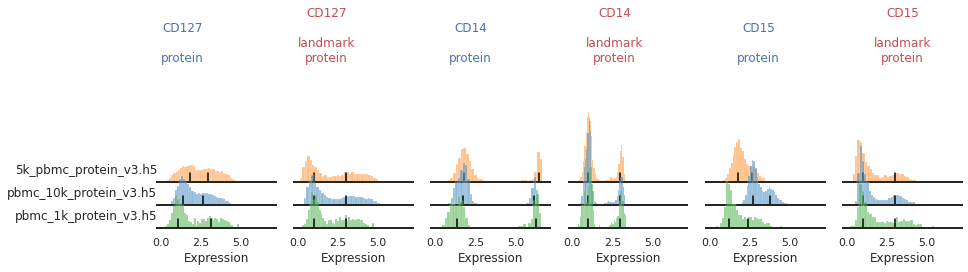

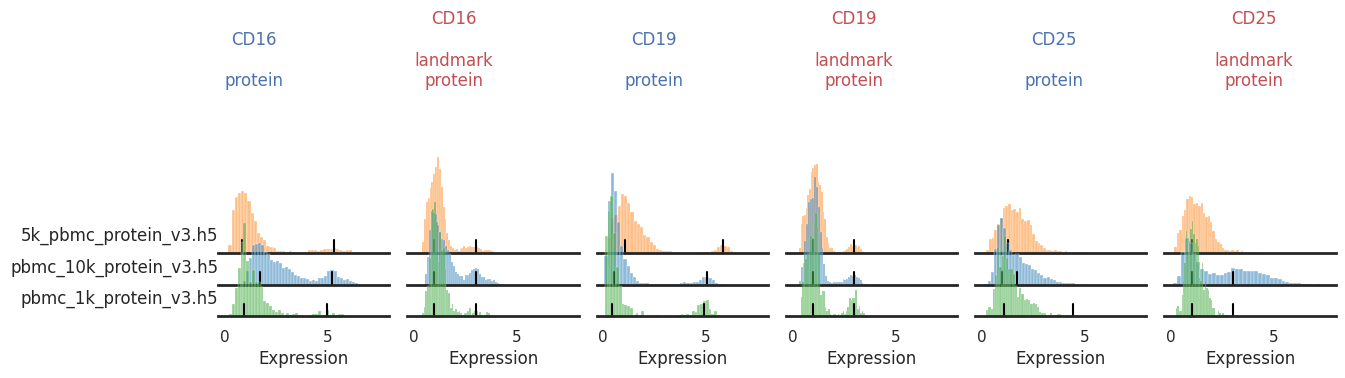

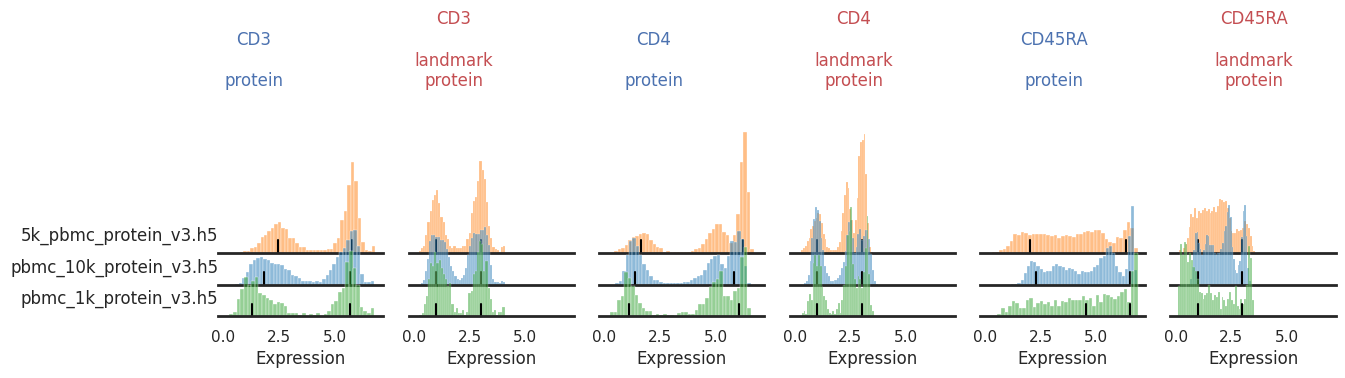

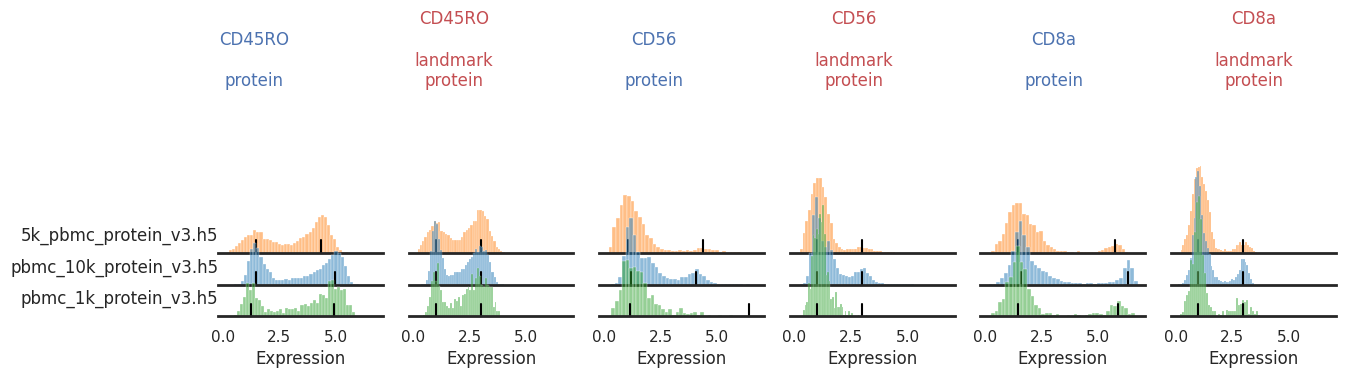

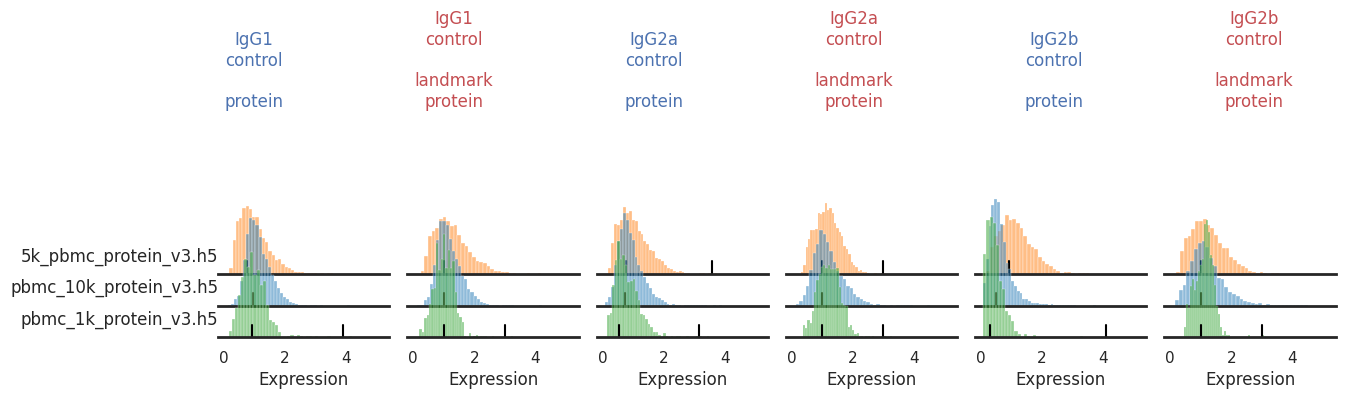

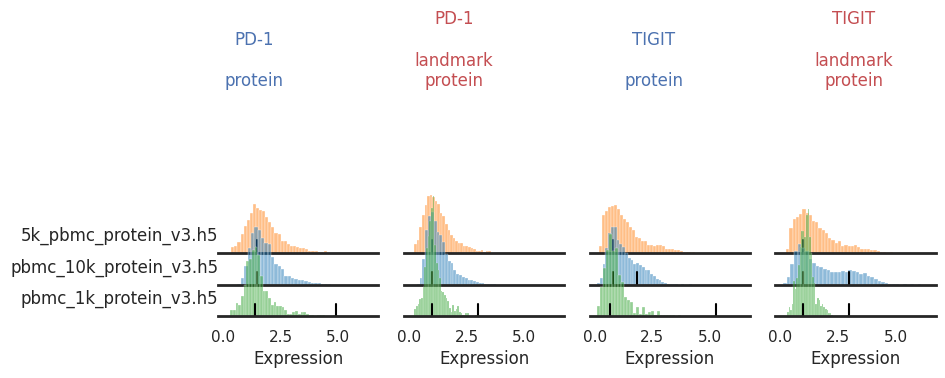

In [4]:
marker_to_process = sorted(adata.obsm['protein'].columns)
chunk_size=3
for i in range(0,len(marker_to_process),chunk_size):
    mmc.stacked_density_plots(adata,marker_to_process[i:i+chunk_size],'batch',['protein', 'landmark_protein'],height=1,aspect=2,subsample=1)

For most markers, landmark registration appears to have done a good job. You can see how non-overlapping peaks are now sat on top of eachother, and also see what data is and is not preserved in landmark registration. The units of expression become meaningless, but the relative position of the peaks corresponding to positive, (sometimes mid), and negative expression is now equalized across the data. This is critical for some downstream analyses, most notably for us—classification.

You may also be able to readily identify some spots where peak identification appears to have failed. This includes: 
- IgG1_control, IgG2a_control, IgG2b_control - single peaks
- CD25, PD-1 - Gradient of expression
- CD4, CD45RA - incorrectly called peaks, bandwidth issues (of trimodal expression)
- CD56, TIGIT- inconsistent peak calling 

Let's take a closer look at some of these and identify ways to tweak the algorithm to fix them.

## <b style='color:orange'>Defining single peaks</b> 
For some markers, most notably our isotype controls, we don't expect to see (nor do we see) a clear positive population. Yet on some batches, the peak identification is accidentally identifying a second peak. 

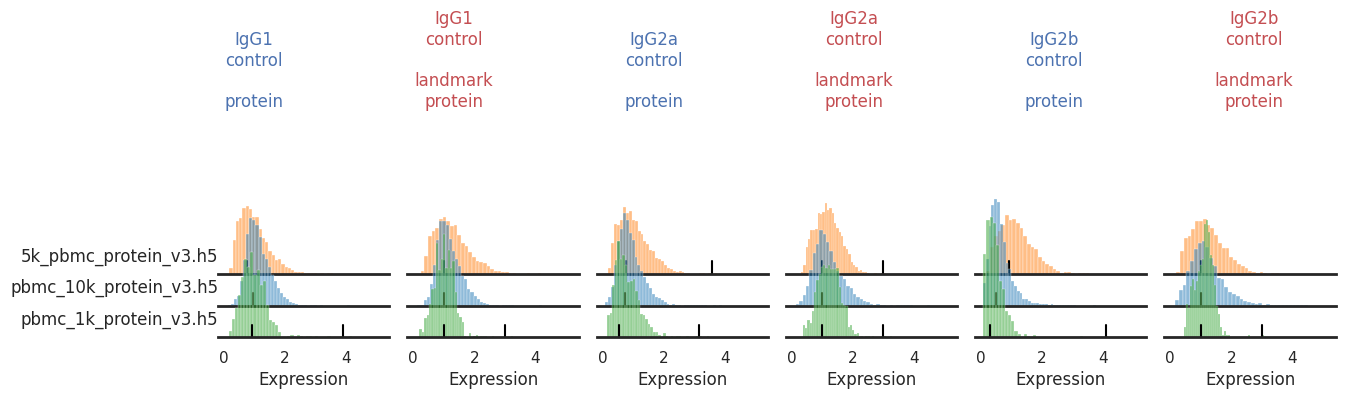

In [5]:
mmc.stacked_density_plots(adata,['IgG1_control','IgG2a_control','IgG2b_control'],'batch',['protein', 'landmark_protein'],height=1,aspect=2,subsample=1)

For this we can create a list of markers that should only have a single-peak. Passing this list later to landmark registration will solve these strange positive peak calls.

In [6]:
single_peaks = ['IgG1_control','IgG2a_control','IgG2b_control']

Other markers, there may be a gradient of expression, and it may be hard to define a clear positive or negative peak. For these as well, we may choose to align them as single-peaks. We could also carefully manually define positive and negative peaks, which may better reflect expression and align with flow-gating strategies. Here, with no clear positive signal, I will just set them to single peaks.

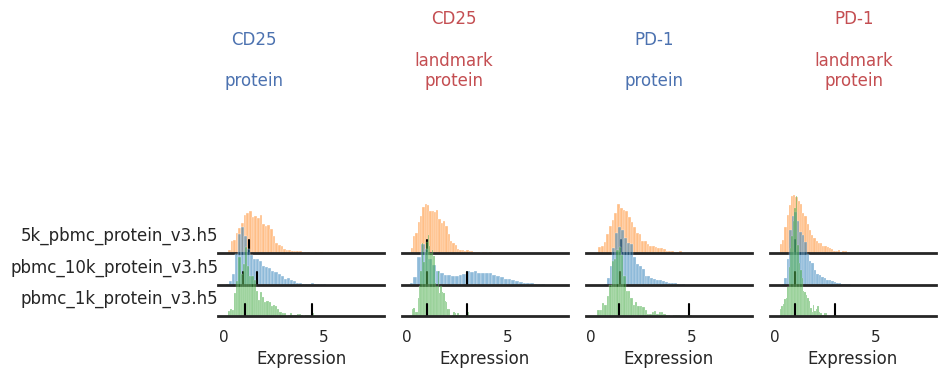

In [7]:
mmc.stacked_density_plots(adata,['CD25','PD-1'],'batch',['protein', 'landmark_protein'],height=1,aspect=2,subsample=1)

In [8]:
single_peaks = single_peaks+['CD25','PD-1']

## <b style='color:orange'>Altering bandwidths</b> 
For other markers, peak identification appears to have failed across the different batches. Peak identification is performed on the smoothed kernel density estimation (KDE) of the histogram. The level of smoothing performed is the bandwidth. Let's see how altering this bandwidth affects various markers. Below are our histograms for two trimodal markers: CD4 and CD45RA. 

What seems to be happening here is that the pos- and mid-peaks are being smoothed together in the KDE approximation, leading to a peak identification that isn't quite centered on the most positive peak. 

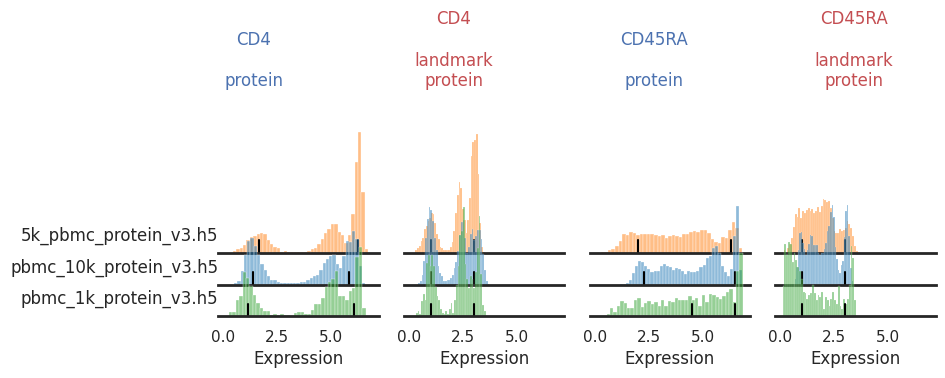

In [9]:
mmc.stacked_density_plots(adata,['CD4','CD45RA'],'batch',['protein', 'landmark_protein'],height=1,aspect=2)

The default smoothing applied is at a bandwidth adjustment of 0.2, so let's look at that:

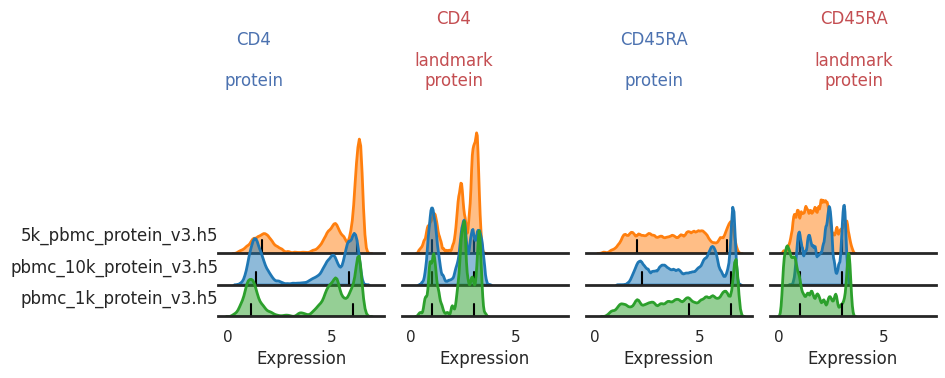

In [10]:
mmc.stacked_density_plots(adata,['CD4','CD45RA'],'batch',['protein', 'landmark_protein'],height=1, aspect=2,bw_adjust=0.2)

Let's take an even closer look at `CD4` on each of the batches to see where peak identification is going wrong.

As a convenience functon, we have also provided `mmc.update_landmark_register` which can recalculate landmark registration on a single marker, for a single batch. This can be a great way to see how your individual edits affect landmark registration without reruning the entire dataset. Using `show`, you can also increase verbosity to see more information about the peaks. 

The red x's identify locations where peaks are called. Peaks are identified using the 1st and 2nd derivatives of the KDE-smoothed expression histogram. Shown here are the KDE-smoothed expression and 1st derivative. Yellow dots (not shown here) represent local maxima/minima in the function that were excluded for one of various reasons (such as being too close to another identified peak). The green dots identify landmarks identified in the 2nd derivative, which could indicate populations that don't quite form a distinct peak.

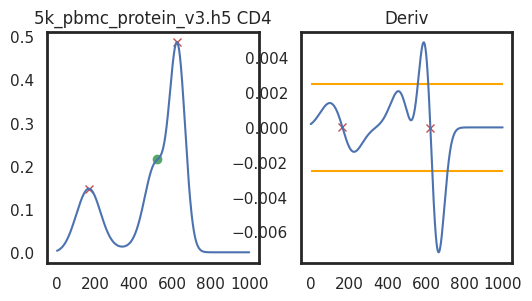

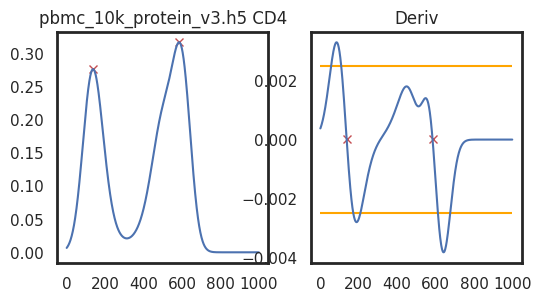

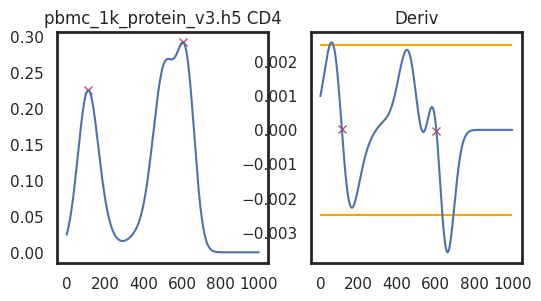

In [11]:
adata = mmc.update_landmark_register(adata, '5k_pbmc_protein_v3.h5', 'CD4',batch_key='batch',show=2)
adata = mmc.update_landmark_register(adata, 'pbmc_10k_protein_v3.h5', 'CD4',batch_key='batch',show=2)
adata = mmc.update_landmark_register(adata, 'pbmc_1k_protein_v3.h5', 'CD4',batch_key='batch',show=2)

As you can see on `pbmc_10k_protein_v3.h5`, it appears that the middle and positive peaks have been merged together by the KDE, leading to a peak identified in between the two of them. The effect this has on the landmark registration is quite minor in this example, but these can have major effects on other samples, so let's look into fixing it.

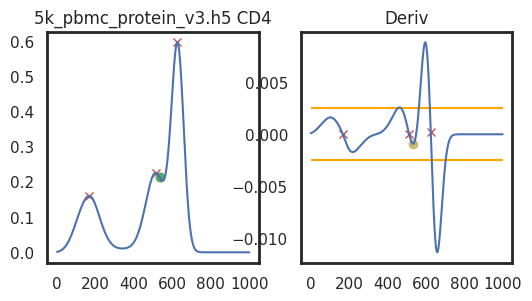

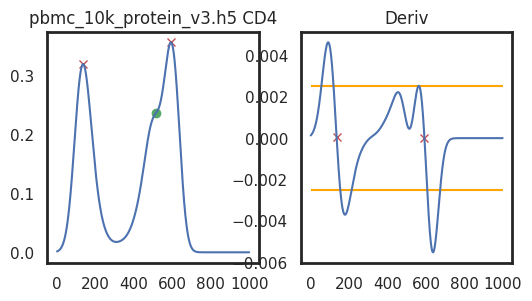

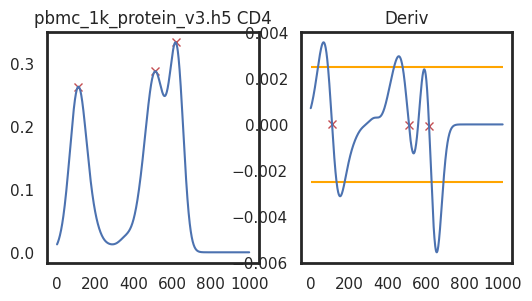

In [12]:
adata = mmc.update_landmark_register(adata, '5k_pbmc_protein_v3.h5', 'CD4',batch_key='batch',show=2, bandwidth=0.15)
adata = mmc.update_landmark_register(adata, 'pbmc_10k_protein_v3.h5', 'CD4',batch_key='batch',show=2, bandwidth=0.15)
adata = mmc.update_landmark_register(adata, 'pbmc_1k_protein_v3.h5', 'CD4',batch_key='batch',show=2, bandwidth=0.15)

So here, changing the bandwidth to a lower number (reducing the amount of smoothing) led to a more correct peak identification. Now let's look into CD45RA.

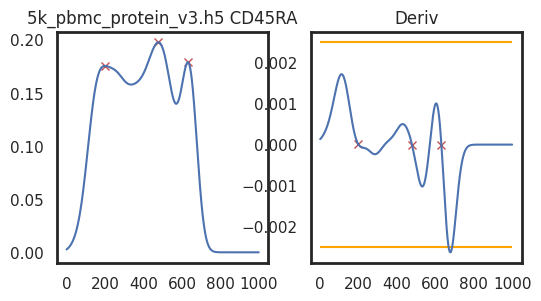

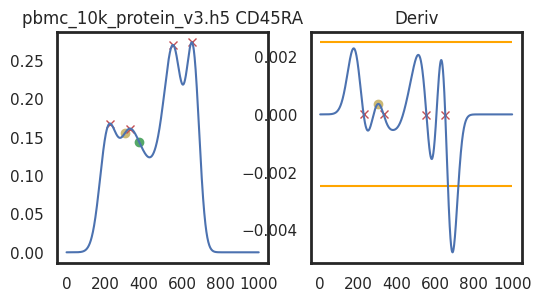

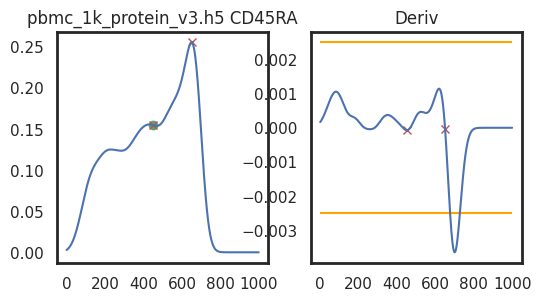

In [13]:
adata = mmc.update_landmark_register(adata, '5k_pbmc_protein_v3.h5', 'CD45RA',batch_key='batch',show=2)
adata = mmc.update_landmark_register(adata, 'pbmc_10k_protein_v3.h5', 'CD45RA',batch_key='batch',show=2)
adata = mmc.update_landmark_register(adata, 'pbmc_1k_protein_v3.h5', 'CD45RA',batch_key='batch',show=2)

Here there's a slightly different issue. On `pbmc_1k_protein_v3.h5`, it appears that the negative peak isn't prominent enough to be identified using this KDE-smoothing. Let's try out a different bandwidth to see if this can be fixed.

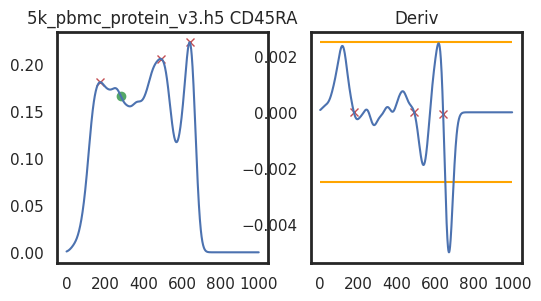

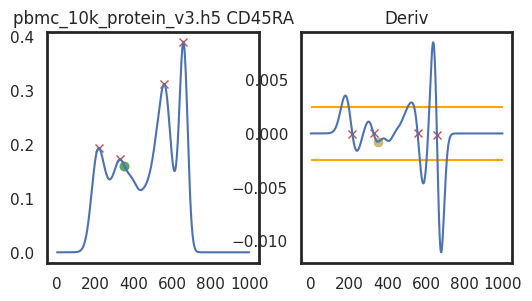

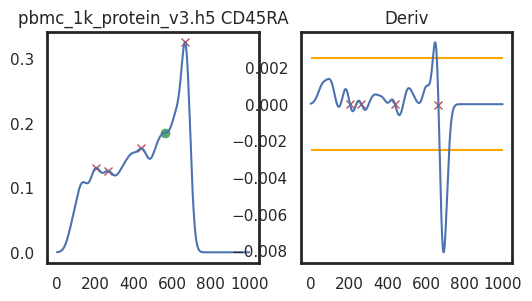

In [14]:
adata = mmc.update_landmark_register(adata, '5k_pbmc_protein_v3.h5', 'CD45RA',batch_key='batch',show=2, bandwidth=0.12)
adata = mmc.update_landmark_register(adata, 'pbmc_10k_protein_v3.h5', 'CD45RA',batch_key='batch',show=2, bandwidth=0.12)
adata = mmc.update_landmark_register(adata, 'pbmc_1k_protein_v3.h5', 'CD45RA',batch_key='batch',show=2, bandwidth=0.12)

Now you can see that these markers are both aligned much more consistently across batches!

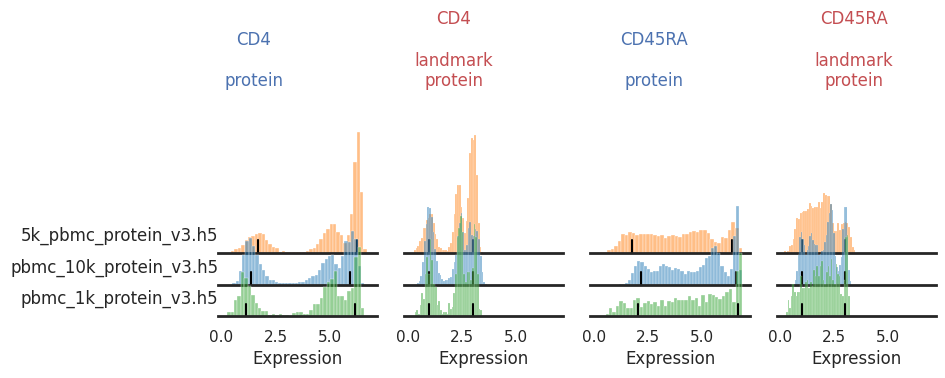

In [15]:
mmc.stacked_density_plots(adata,['CD4','CD45RA'],'batch',['protein', 'landmark_protein'],height=1,aspect=2)

Once we have identified good bandwidths to use, we need to store these in a dictionary to pass to landmark registration for our next run. We can format a dictionary as such:

In [16]:
marker_bandwidths = {'CD4':0.15,'CD45RA':0.12}

## <b style='color:orange'>Manual Overrides</b> 
With these two tools above, you can adjust peak identification pretty effectively across the dataset. Sometimes, however, your eyes and biological insight can do a much better job than our hardcoded algorithm will ever do. 

In those cases, you need to use manual overrides, and just define the landmarks (peaks) the algorithm should be detecting. 

In [17]:
peak_overrides = {}

Let's take another look at the markers we identified as issues. Here, the issues stem from too-few events in `pbmc_1k_protein_v3.h5` being present in the positive peaks

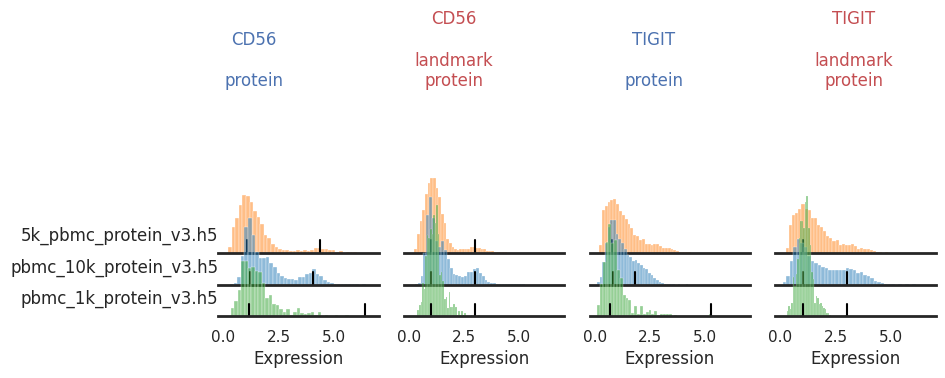

In [18]:
mmc.stacked_density_plots(adata,['CD56','TIGIT'],'batch',['protein', 'landmark_protein'],height=1,aspect=2)

This is the most tedious part of landmark registration, so I have built a list of codeblocks that can be run sequentially to get through this quickly:

In [19]:
marker = 'CD56' # TIGIT

In [20]:
# View currently set peak overrides on that marker across all batches
for b in sorted(peak_overrides.keys()):
    if marker in peak_overrides[b]:
        print(b, peak_overrides[b][marker])

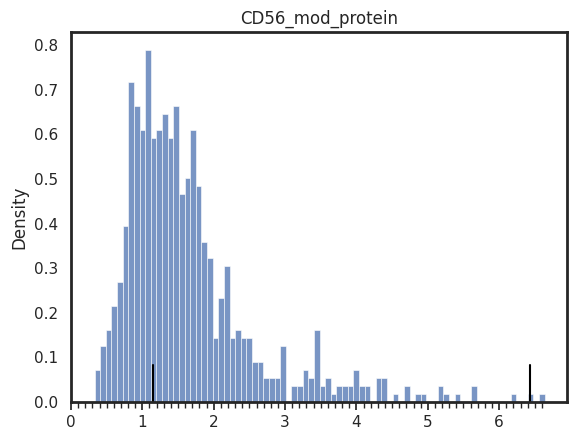

The current peaks sit at [1.1511511511511512, 6.426426426426427]


In [21]:
# Pick a batch, and view a close-up of its original peak identification
batch = 'pbmc_1k_protein_v3.h5'
mmc.density_plot(adata[adata.obsm['protein'][marker]>0],marker,batch,'batch','protein',bw_adjust=0,step=0.1)
print(f"The current peaks sit at {adata.uns['protein_peaks'][batch][marker]}")

In [22]:
# Upadte the peak overrides. To keep current upper or lower peak, use False, to force a single neg or positive, use None for update_upper or update_lower respectively
peak_overrides = mmc.update_peak_overrides(batch, marker, update_lower=False, update_upper=3.5, peak_overrides=peak_overrides,
                                           current_peaks=adata.uns['protein_peaks'])
print(f"Set peak_overrides['{batch}']['{marker}'] = {peak_overrides[batch][marker]}")

Set peak_overrides['pbmc_1k_protein_v3.h5']['CD56'] = [1.1511511511511512, 3.5]


In [23]:
adata = mmc.update_landmark_register(adata, batch, marker, override=peak_overrides, 
                             batch_key = 'batch', data_key = 'protein', key_added = 'landmark_protein', show=False, 
                            single_peak=single_peaks, bandwidth=marker_bandwidths if marker in marker_bandwidths else 0.2)

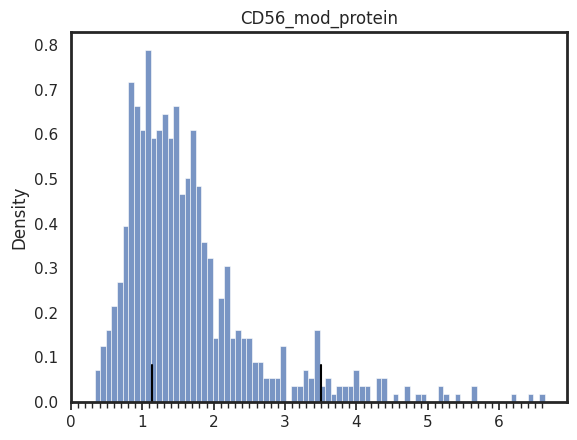

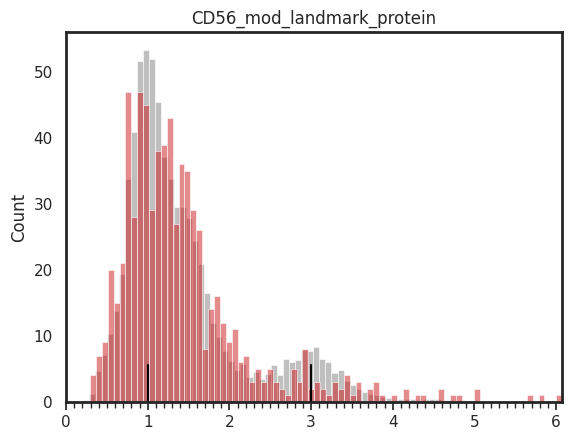

In [24]:
# Display the protein peak identification, and the landmark registration atop all the other batches
mmc.density_plot(adata[adata.obsm['protein'][marker]>0],marker,batch,'batch','protein',bw_adjust=0,step=0.1)
mmc.density_plot_total(adata,marker,batch,'batch','landmark_protein')

In [25]:
if False: # Alternatively, to remove an override
    del peak_overrides[batch][marker]

In [26]:
# Print to notebook to have a temporary save of the updated variables, to quickly revert changes, or for updating above.
print('peak_overrides =',peak_overrides,end='\n\n')
print('single_peaks =',single_peaks,end='\n\n')
print('marker_bandwidths =',marker_bandwidths)

peak_overrides = {'pbmc_1k_protein_v3.h5': {'CD56': [1.1511511511511512, 3.5]}}

single_peaks = ['IgG1_control', 'IgG2a_control', 'IgG2b_control', 'CD25', 'PD-1']

marker_bandwidths = {'CD4': 0.15, 'CD45RA': 0.12}


These peak overrides can get quite long, especially with many batches, or large TotalSeq cocktails of ADTs, so we've also implemented a function to save these to a json and load them back in:

In [27]:
save_path = 'data/overrides.json'
mmc.save_peak_overrides(save_path,peak_overrides)
loaded_overrides = mmc.load_peak_overrides(save_path)

Great, now go back up and do the same for `TIGIT` on this batch, and on `5k_pbmc_protein_v3.h5`

This is code you can run through iteratively as you evaluate the performance of your landmark registration. 

<div class="alert alert-block alert-info">
<b>Tip — Cleaning up more:</b> Have you identified any other issues in the landmark registration above (e.g. on other markers or batches)? If so, you can edit them here as well! I've written this document to try to provide a good framework for what to look for. Look into the documentation of each of these functions as well to get a better idea what altering each parameter does.</div>

## <b style='color:orange'>Running it all together</b> 
Now that we've made all these modifications, lets put it all together and rerun landmark registration! I've defined all my overrides here so that you can run the next function and get the same output as me.

In [28]:
peak_overrides = {'pbmc_1k_protein_v3.h5': {'CD56': [1.1411411411411412, 3.5], 
                                            'TIGIT': [0.6806806806806807, 2.5]}, 
                  '5k_pbmc_protein_v3.h5': {'TIGIT': [0.8008008008008007, 2.9]}}

single_peaks = ['IgG1_control', 'IgG2a_control', 'IgG2b_control', 'CD25']
marker_bandwidths = {'CD4': 0.15, 'CD45RA': 0.12}

In [29]:
adata = mmc.landmark_register_adts(adata,'batch',data_key='protein',single_peaks=single_peaks,
                                   marker_bandwidths=marker_bandwidths,peak_overrides=peak_overrides)

Running with batch batch


  0%|          | 0/3 [00:00<?, ?it/s]

Once the landmark registration has run, this code block will plot all the ADTs in alphabetical order. 

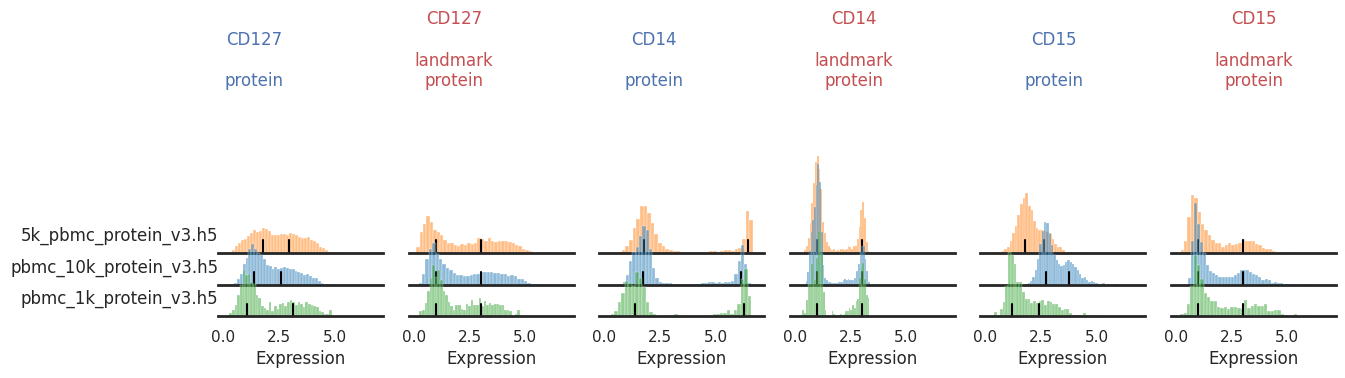

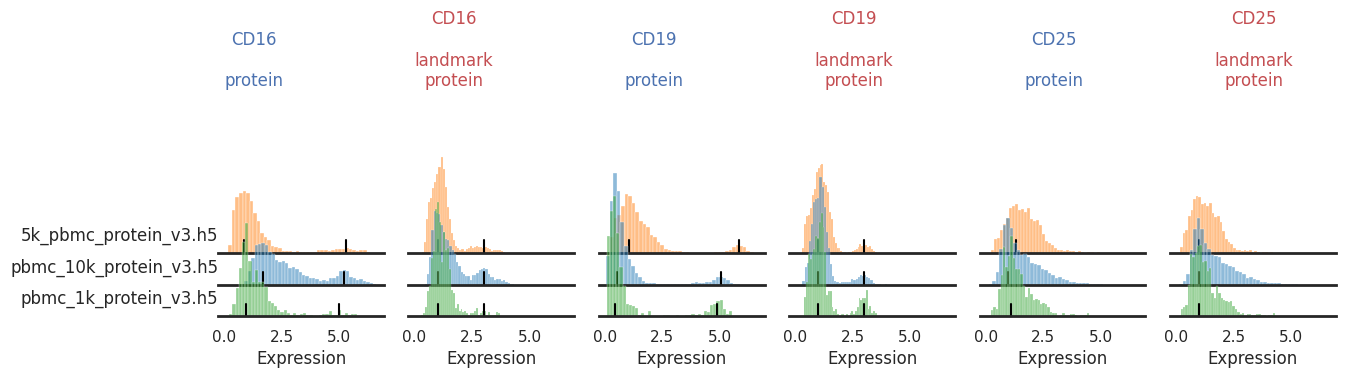

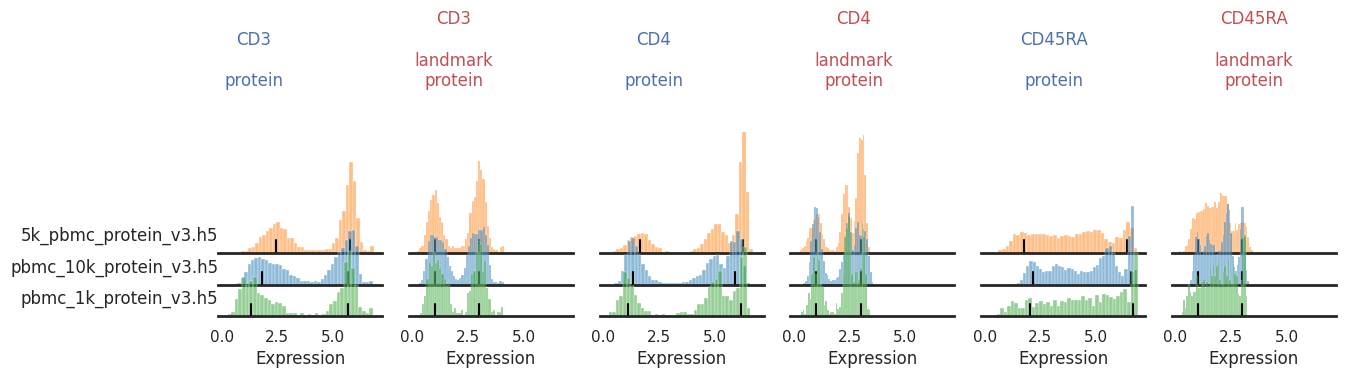

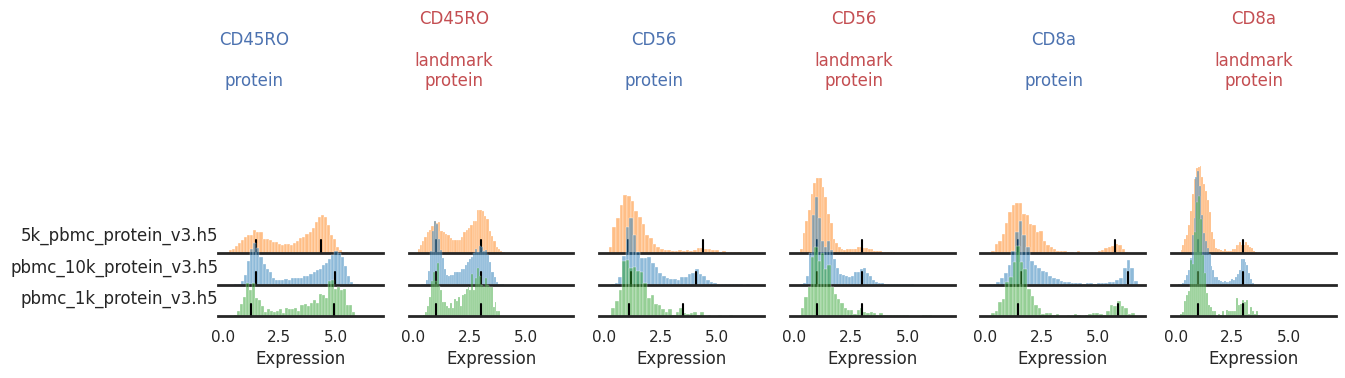

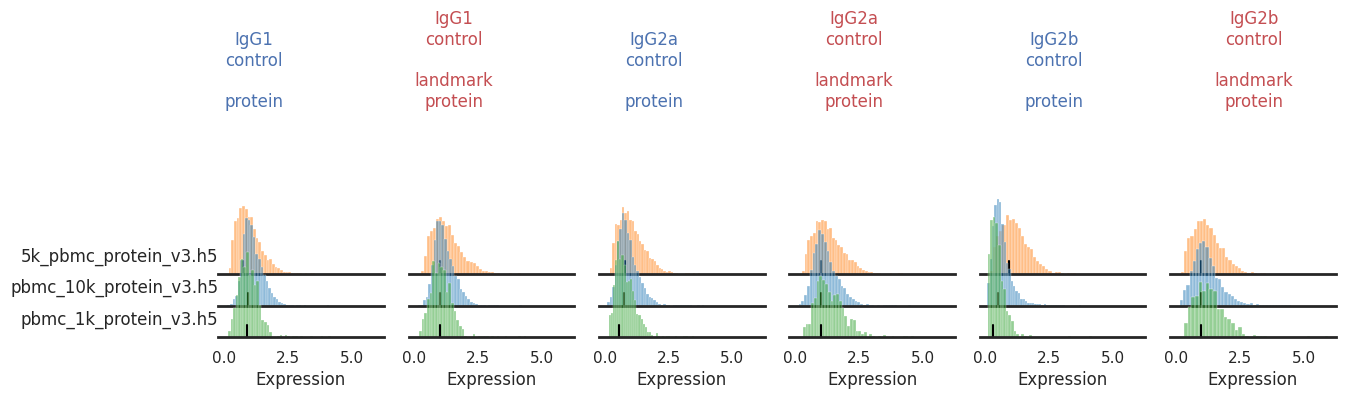

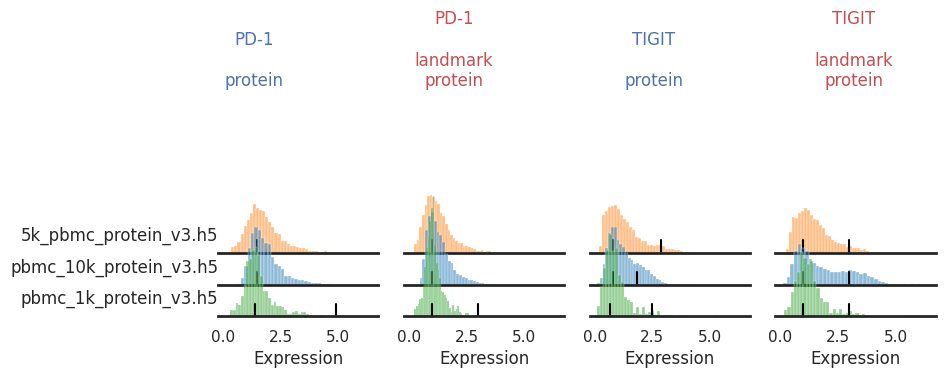

In [30]:
marker_to_process = sorted(adata.obsm['protein'].columns)
chunk_size=3
for i in range(0,len(marker_to_process),chunk_size):
    mmc.stacked_density_plots(adata,marker_to_process[i:i+chunk_size],'batch',['protein', 'landmark_protein'],height=1,aspect=2,subsample=1)

<div class="alert alert-block alert-success">
<b>Great!</b> This looks much improved and will perform better when we run MMoCHi on it!<br>
</div>